Global validation of `dtr`

`da_hist` and `da_ssp370` are data inputs from the cleaned CMIP6 data. 

The data we are comparing:
`da_cmip6` is the regridded data input. `da_bc` is the bias-corrected CMIP6 data. `da_era5` is the ERA-5 reanalysis data. 

In [1]:
%matplotlib inline
import xarray as xr
import numpy as np 
import os 
import pandas as pd 

import matplotlib.pyplot as plt
from matplotlib import cm
from cartopy import config
import cartopy.crs as ccrs
import cartopy.feature as cfeature

import intake
import zarr
import gcsfs

import dask.array as dda

In [2]:
fs = gcsfs.GCSFileSystem(token='/opt/gcsfuse_tokens/impactlab-data.json')

In [3]:
'''store_filename = 'gs://impactlab-data/climate/downscaling/clean-cmip6-validation-20210722/ACCESS-ESM1-5/historical/r1i1p1f1/dtr.zarr' 
store = fs.get_mapper(store_filename, check=False)
ds_hist = xr.open_zarr(store, consolidated=True)'''

"store_filename = 'gs://impactlab-data/climate/downscaling/clean-cmip6-validation-20210722/ACCESS-ESM1-5/historical/r1i1p1f1/dtr.zarr' \nstore = fs.get_mapper(store_filename, check=False)\nds_hist = xr.open_zarr(store, consolidated=True)"

In [4]:
# da_hist = ds_hist['dtr']

In [5]:
store_filename = 'gs://impactlab-data-scratch/regrid-test-lv4s6/ACCESS-ESM1-5/dtr/gcm-future-regrid.zarr' 
store = fs.get_mapper(store_filename, check=False)
ds_ssp370 = xr.open_zarr(store, consolidated=True)

In [6]:
da_ssp370 = ds_ssp370['dtr']

Zarr stores that are used below.

In [7]:
store_filename = 'gs://impactlab-data-scratch/regrid-test-lv4s6/ACCESS-ESM1-5/dtr/biascorrected-rechunked.zarr'
store = fs.get_mapper(store_filename, check=False)
ds_bc = xr.open_zarr(store, consolidated=True)

In [9]:
da_bc = ds_bc['dtr']
# da_bc

In [10]:
store_filename = 'gs://impactlab-data/climate/downscaling/biascorrected-validation-20210727/ERA-5/dtr/reference-regrid.zarr'
store = fs.get_mapper(store_filename, check=False)
ds_era5 = xr.open_zarr(store, consolidated=True)

In [11]:
da_era5 = ds_era5['dtr']

In [12]:
da_era5_v2 = da_era5.sel(time=slice('1995','2014'))
da_era5_v2

<xarray.DataArray 'dtr' (time: 7300, lat: 180, lon: 360)>
dask.array<getitem, shape=(7300, 180, 360), dtype=float32, chunksize=(365, 180, 360), chunktype=numpy.ndarray>
Coordinates:
    dayofyear  (time) int64 dask.array<chunksize=(7300,), meta=np.ndarray>
  * lat        (lat) float64 -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * lon        (lon) float64 -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
  * time       (time) object 1995-01-01 00:00:00 ... 2014-12-31 00:00:00

In [13]:
'''store_filename = 'gs://impactlab-data/climate/downscaling/biascorrected-validation-20210727/ACCESS-ESM1-5/dtr/gcm-future-regrid.zarr'
store = fs.get_mapper(store_filename, check=False)
ds_cmip6 = xr.open_zarr(store, consolidated=True)'''

"store_filename = 'gs://impactlab-data/climate/downscaling/biascorrected-validation-20210727/ACCESS-ESM1-5/dtr/gcm-future-regrid.zarr'\nstore = fs.get_mapper(store_filename, check=False)\nds_cmip6 = xr.open_zarr(store, consolidated=True)"

In [14]:
# da_cmip6 = ds_cmip6['dtr']

Defining time periods of interest

In [15]:
start_20yr_periods = ['2020', '2040', '2060', '2080']
end_20yr_periods = ['2040', '2060', '2080', '2100']

In [16]:
def compare_da_to_threshold_per_year(da, method, climo, threshold):
    if method == 'above':
        days_per_threshold = da.where(da > threshold)
    elif method == 'below': 
        days_per_threshold = da.where(da < threshold)
     
    if climo == 'no':
        # count instances of occurrance, average per year for average number of days above threshold
        days_threshold_per_yr = days_per_threshold.groupby(days_per_threshold.time.dt.year).count().mean(dim='year').persist()
        return days_threshold_per_yr
    else:
        days_threshold_per_yr = days_per_threshold.count(dim='dayofyear').persist()
        return days_threshold_per_yr
    
def plot_average_days_above_threshold(da, threshold_value, start_yr, end_yr, fname):    
    fig = plt.figure(figsize=(10, 5))
    ax = plt.axes(projection=ccrs.Robinson())
    cmap = cm.hot_r 

    da.plot(
        ax=ax,
        cmap=cmap,
        transform=ccrs.PlateCarree(),
        cbar_kwargs={"label": "# of days"},
        vmin=0,
        vmax=300,
    )

    ax.coastlines()
    ax.add_feature(cfeature.BORDERS, linestyle=":")
    ax.set_title("Average number of days above {}F per year from {}-{}".format(threshold_value, start_yr, end_yr))
    
    plt.savefig(fname, dpi=600, bbox_inches='tight')
    
def plot_difference_days(da1, da2, title, fname):    
    fig = plt.figure(figsize=(10, 5))
    ax = plt.axes(projection=ccrs.Robinson())
    cmap = cm.RdBu_r

    (da1-da2).plot(
        ax=ax,
        cmap=cmap,
        transform=ccrs.PlateCarree(),
        cbar_kwargs={"label": "# of days"},
        vmin=-100,
        vmax=100,
    )

    ax.coastlines()
    ax.add_feature(cfeature.BORDERS, linestyle=":")
    ax.set_title(title)
    
    plt.savefig(fname, dpi=600, bbox_inches='tight')

In [34]:
def plot_globe(da, metric, start_yr, end_yr, data_type, fname):    
    fig = plt.figure(figsize=(10, 5))
    ax = plt.axes(projection=ccrs.Robinson())
    cmap = cm.cividis 
    
    if metric == 'mean':
        da.sel(time=slice(start_yr,end_yr)).mean(dim='time').plot(
            ax=ax,
            cmap=cmap,
            transform=ccrs.PlateCarree(),
            cbar_kwargs={'shrink': 0.8, 'pad': 0.02, "label": "DTR (K)"},
            vmin=0,
            vmax=16,
            # robust=True,
        )
    elif metric == 'max':
        da.sel(time=slice(start_yr,end_yr)).max(dim='time').plot(
            ax=ax,
            cmap=cmap,
            transform=ccrs.PlateCarree(),
            cbar_kwargs={'shrink': 0.8, 'pad': 0.02, "label": "DTR (K)"},
            #vmin=240,
            #vmax=310,
        )
    elif metric == 'min':
        da.sel(time=slice(start_yr,end_yr)).min(dim='time').plot(
            ax=ax,
            cmap=cmap,
            transform=ccrs.PlateCarree(),
            cbar_kwargs={'shrink': 0.8, 'pad': 0.02, "label": "dtr (K)"},
            #vmin=240,
            #vmax=310,
        )

    ax.coastlines()
    ax.add_feature(cfeature.BORDERS, linestyle=":")
    ax.set_title("{} DTR ({}-{}), {}".format(metric, start_yr, end_yr, data_type))
    
    plt.savefig(fname, dpi=600, bbox_inches='tight')
    
def plot_difference_temp(da1, da2, title, fname):    
    fig = plt.figure(figsize=(10, 5))
    ax = plt.axes(projection=ccrs.Robinson())
    cmap = cm.RdBu_r

    (da1-da2).plot(
        ax=ax,
        cmap=cmap,
        transform=ccrs.PlateCarree(),
        cbar_kwargs={'shrink': 0.8, 'pad': 0.02, "label": "dtr (K)"},
        vmin=-5,
        vmax=5,
    )

    ax.coastlines()
    ax.add_feature(cfeature.BORDERS, linestyle=":")
    ax.set_title(title)
    
    plt.savefig(fname, dpi=600, bbox_inches='tight')

In [35]:
# count instances of occurrance, average per year for average number of days above threshold
high_dtr_threshold = 15

Mean dtr of bias-corrected, CMIP6 (2080-2100) and ERA-5 (1995-2014)

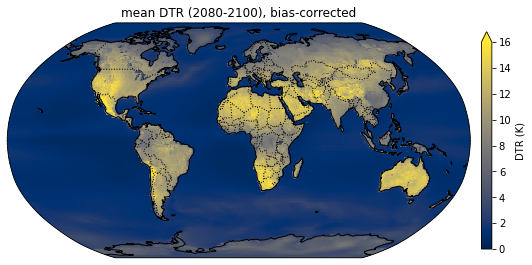

In [36]:
plot_globe(da_bc, 'mean', start_20yr_periods[3], end_20yr_periods[3], 'bias-corrected', 'mean_bc_2080_2100')

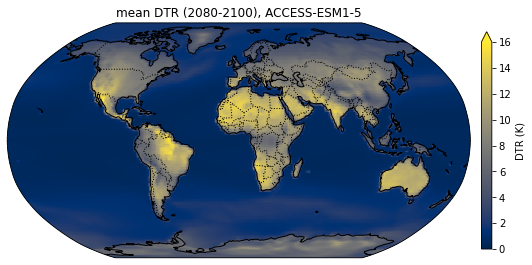

In [37]:
plot_globe(da_ssp370, 'mean', start_20yr_periods[3], end_20yr_periods[3], 'ACCESS-ESM1-5', 'mean_access1_2080_2100')

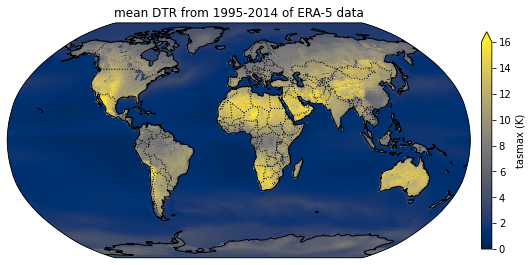

In [30]:
plot_globe(da_era5, 'mean', '1995', '2014', 'ERA-5', 'mean_era5_1995_2014')

In [ ]:
plot_difference_temp(da_bc.mean(dim='time'), da_era5_v2.mean(dim='time'),
                     'Mean dtr difference between bias-corrected and ERA-5', 'dtr_mean_diff_BC_era5')

In [ ]:
plot_difference_temp(da_cmip6.mean(dim='time'), da_era5_v2.mean(dim='time'), 
                     'Mean dtr difference between ACCESS-EMS1-5 and ERA-5', 'dtr_mean_diff_ACCESS_era5')

/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


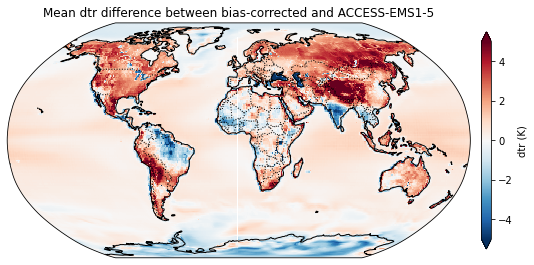

In [36]:
plot_difference_temp(da_bc.mean(dim='time'), da_cmip6.mean(dim='time'), 
                     'Mean dtr difference between bias-corrected and ACCESS-EMS1-5', 'dtr_mean_diff_BC_ACCESS')

Average annual count of days with high `dtr` (above 15K)

In [ ]:
days_above_threshold_bc = compare_da_to_threshold_per_year(da_bc.sel(time=slice(start_20yr_periods[3],end_20yr_periods[3])),
                                                           'above', 'no', high_heat_threshold)

In [ ]:
days_above_threshold_cmip6 = compare_da_to_threshold_per_year(da_cmip6.sel(time=slice(start_20yr_periods[3],end_20yr_periods[3])),
                                                           'above', 'no', high_heat_threshold)

In [ ]:
days_above_threshold_era5 = compare_da_to_threshold_per_year(da_era5_v2,
                                                           'above', 'no', high_heat_threshold)

Plot global maps of average days above 15K `dtr`

In [ ]:
plot_average_days_above_threshold(days_above_threshold_bc, 95, start_20yr_periods[3], end_20yr_periods[3], 'daysabove95_bc_2080-2100')

In [ ]:
plot_average_days_above_threshold(days_above_threshold_cmip6, 95, start_20yr_periods[3], end_20yr_periods[3], 'daysabove95_cmip6_2080-2100')

In [ ]:
plot_average_days_above_threshold(days_above_threshold_era5, 95, '1995', '2014', 'daysabove95_era5_1995-2014')

Plot difference between number of days above 15K `dtr`

In [ ]:
plot_difference_days(days_above_threshold_bc, days_above_threshold_era5, 
                     'Bias-corrected (2080-2100) minus ERA-5 (1995-2014)', 'diff_daysabove95_bc_era5')

In [ ]:
plot_difference_days(days_above_threshold_cmip6, days_above_threshold_era5,
                     'CMIP6 (2080-2100) minus ERA-5 (1995-2014)', 'diff_daysabove95_cmip6_era5')

In [ ]:
plot_difference_days(days_above_threshold_bc, days_above_threshold_cmip6, 
                     'Bias-corrected (2080-2100) minus CMIP6 (2080-2100)', 'diff_daysabove95_bc_cmip6')